In [1]:
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from scipy import sparse
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import torch
import torch.nn as nn

In [2]:
load_dotenv()

True

In [3]:
phish_path = os.getenv("PHISHING_PATH_TWO")
phish_csv = pd.read_csv(phish_path)

In [4]:
phish_csv 

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [5]:
phish_csv["phishing"].value_counts()

0    58000
1    30647
Name: phishing, dtype: int64

In [6]:
ham_csv = phish_csv[phish_csv["phishing"] == 0].head(30647).reset_index(drop=True)
spam_csv = phish_csv[phish_csv["phishing"] == 1].reset_index(drop=True)

phish_csv = pd.concat([ham_csv, spam_csv], axis=0).reset_index(drop=True)

phish_csv

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,1,2,2,291,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,3134,1,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3596,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61289,2,1,0,3,0,0,0,0,0,0,...,1,2,2,3598,0,0,0,0,0,1
61290,3,1,0,2,0,0,0,0,0,0,...,1,2,2,55,1,0,0,0,0,1
61291,2,1,0,4,0,0,0,0,0,0,...,1,2,1,899,1,0,0,0,0,1
61292,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1


In [7]:
phish_csv = phish_csv.sample(frac=1).head(5_000).reset_index(drop=True)

In [8]:
phish_csv.columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url',
       ...
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects', 'url_google_index',
       'domain_google_index', 'url_shortened', 'phishing'],
      dtype='object', length=112)

In [9]:
len(phish_csv.columns)

112

In [10]:
col = ["email_in_url", 
       "domain_in_ip",
       "server_client_domain",
       "tld_present_params",
       "domain_spf",
       "tls_ssl_certificate",
       "url_google_index",
       "domain_google_index",
       "url_shortened",
       "phishing"]

In [11]:
col_list = [phish_csv.pop(i) for i in col]

In [12]:
drop_columns = []

for i in phish_csv.columns:
    
    drop_columns = (drop_columns + [i]) if phish_csv[i].min() == phish_csv[i].max() else drop_columns
    
#     if phish_csv[i].min() == -1:
#         drop_columns += 1
    
#     print(phish_csv[i].min(), phish_csv[i].max())
#     print(i)
    
    
phish_csv = phish_csv.drop(columns=drop_columns)


In [13]:
bool_csv = pd.concat(col_list, axis=1)
bool_csv["tld_present_params"] += 1
bool_csv["domain_spf"] += 1

bool_csv

,email_in_url,domain_in_ip,server_client_domain,tld_present_params,domain_spf,tls_ssl_certificate,url_google_index,domain_google_index,url_shortened,phishing
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,2,0,0,0,0,1
2,0,0,0,0,1,1,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,1,1,0,0,0,0,1
4996,0,0,0,0,1,1,0,0,0,1
4997,0,0,0,0,1,0,0,0,0,1
4998,0,0,0,1,2,1,0,0,0,1


In [14]:
scaler = StandardScaler()


data = scaler.fit_transform(phish_csv.to_numpy())

data

array([[-0.1917742 , -0.33141663, -0.1996327 , ..., -0.41642154,
        -0.60199466,  0.89716156],
       [-0.1917742 , -0.33141663, -0.1996327 , ...,  0.77097948,
        -0.26207823, -0.42569536],
       [-0.1917742 , -0.33141663,  1.01467813, ..., -1.01012204,
        -0.60168536, -0.42569536],
       ...,
       [ 0.53519395, -0.33141663,  1.01467813, ..., -0.41642154,
         0.72931892, -0.42569536],
       [-0.1917742 , -0.33141663,  1.01467813, ..., -0.41642154,
         0.1894941 , -0.42569536],
       [-0.91874235, -0.33141663, -0.1996327 , ..., -1.01012204,
        -0.60168536, -0.42569536]])

In [15]:
new_phish_csv = pd.DataFrame(columns = phish_csv.columns, data=data)

In [16]:
new_phish_csv

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_params,time_response,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,qty_redirects
0,-0.191774,-0.331417,-0.199633,-0.815882,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,0.180588,-0.336071,-1.009678,0.495846,-0.142591,-0.575379,-0.416422,-0.601995,0.897162
1,-0.191774,-0.331417,-0.199633,0.635693,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,-0.054501,-0.047608,-1.009678,-0.581611,-0.142591,0.216064,0.770979,-0.262078,-0.425695
2,-0.191774,-0.331417,1.014678,0.635693,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,-0.350478,0.167431,-1.009678,-0.581611,-0.142591,1.007507,-1.010122,-0.601685,-0.425695
3,-0.918742,-0.331417,1.014678,1.119552,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,0.099141,-0.159708,-1.009678,-0.581611,-0.142591,-0.575379,-0.416422,0.622921,2.220018
4,-0.191774,-0.331417,-0.199633,-0.815882,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,-0.188770,-0.357078,1.040369,-0.257274,-0.142591,-0.575379,-0.416422,0.628488,-0.425695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.535194,-0.331417,1.014678,1.119552,-0.08406,2.280945,-0.108693,1.606406,-0.036079,-0.025178,...,3.171463,0.016565,0.072593,-1.009678,-0.581611,-0.142591,1.007507,-0.416422,0.666944,2.220018
4996,-0.191774,0.488922,-0.199633,-0.332024,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,-0.299487,-0.395938,-1.003901,0.057900,0.999967,-0.575379,-1.010122,-0.602304,0.897162
4997,0.535194,-0.331417,1.014678,0.635693,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,-0.288000,-0.313544,-0.415194,-1.009678,-0.581611,-0.142591,0.216064,-0.416422,0.729319,-0.425695
4998,-0.191774,-0.331417,1.014678,0.635693,-0.08406,2.280945,-0.108693,1.606406,-0.036079,-0.025178,...,3.171463,-0.307011,-0.260001,1.767893,-0.163822,-0.142591,-0.575379,-0.416422,0.189494,-0.425695


In [17]:
new_phish_csv = pd.concat([new_phish_csv, bool_csv], axis=1)
new_phish_csv

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,email_in_url,domain_in_ip,server_client_domain,tld_present_params,domain_spf,tls_ssl_certificate,url_google_index,domain_google_index,url_shortened,phishing
0,-0.191774,-0.331417,-0.199633,-0.815882,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,0,1,0,0,0,0
1,-0.191774,-0.331417,-0.199633,0.635693,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,2,0,0,0,0,1
2,-0.191774,-0.331417,1.014678,0.635693,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,1,1,0,0,0,1
3,-0.918742,-0.331417,1.014678,1.119552,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,0,1,0,0,0,1
4,-0.191774,-0.331417,-0.199633,-0.815882,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.535194,-0.331417,1.014678,1.119552,-0.08406,2.280945,-0.108693,1.606406,-0.036079,-0.025178,...,0,0,0,1,1,0,0,0,0,1
4996,-0.191774,0.488922,-0.199633,-0.332024,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,1,1,0,0,0,1
4997,0.535194,-0.331417,1.014678,0.635693,-0.08406,-0.238323,-0.108693,-0.170592,-0.036079,-0.025178,...,0,0,0,0,1,0,0,0,0,1
4998,-0.191774,-0.331417,1.014678,0.635693,-0.08406,2.280945,-0.108693,1.606406,-0.036079,-0.025178,...,0,0,0,1,2,1,0,0,0,1


In [18]:
train_df, test_df = train_test_split(new_phish_csv, test_size=0.2, random_state=42)

In [19]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [20]:
def train_models(train_x,
                 train_y,
                 test_x,
                 test_y):
    
    clf_log = LogisticRegression(random_state=0).fit(train_x, train_y)
    clf_svm = svm.SVC(kernel="sigmoid").fit(train_x, train_y)
    # clf_bayes = MultinomialNB().fit(train_x, train_y)
        
    ret_dict = {"Logistic_Regression": clf_log.score(test_x, test_y),
                "Support Vector Classifer": clf_svm.score(test_x, test_y)}
                # "Multinomial Naive Bayes": clf_bayes.score(test_x, test_y)}
    
    return ret_dict

In [21]:
train_y_np = train_df.pop("phishing").to_numpy()
train_x_np = train_df.to_numpy()

test_y_np = test_df.pop("phishing").to_numpy()
test_x_np = test_df.to_numpy()

In [22]:
f_dict = train_models(train_x_np, train_y_np, test_x_np, test_y_np)
f_dict

/Users/sriramgovindan/Documents/CS166/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic_Regression': 0.93, 'Support Vector Classifer': 0.901}

In [47]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(97, 50)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(50, 10)
        self.linear3 = torch.nn.Linear(10, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        
        x = self.activation(self.linear2(x))
        
        return self.sig(self.linear3(x))

In [48]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomPhishingDataset(Dataset):
    def __init__(self, df, label_list):
        self.__df = df
        
        self.__label = label_list

    def __len__(self):
        return len(self.__df)

    def __getitem__(self, idx):
        
        row = self.__df.iloc[idx]
        
#         flags = row.to_numpy().astype(float)
#         label[self.__labels[row["LABEL"]]] = 1
        
        return row.to_numpy().astype(float), self.__label[idx]

In [49]:
train_dataset = CustomPhishingDataset(train_df, train_y_np)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomPhishingDataset(test_df, test_y_np)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [50]:
for i in train_dataloader:
    
    print(i[0].size(),
         i[1].size())
    break

torch.Size([64, 97]) torch.Size([64])


In [70]:
my_model = TinyModel()
criterion = nn.BCELoss()
optim = torch.optim.Adam(my_model.parameters(), lr=0.001)

In [71]:
def get_test():
    
    with torch.no_grad():
        my_model.eval()
        correct = 0
        
        for i in test_dataloader:
            # get the inputs; data is a list of [inputs, labels]
            row, label = i

        
            row = row.to(torch.float32)
            label = label.to(torch.float32)
            
            label = torch.unsqueeze(label, dim=1)
            
            # forward + backward + optimize
            output = my_model(row)
            
            
            output = 1 if output >= 0.5 else 0
            
            if output == label:
                correct+=1


        print(correct / len(test_dataloader))
        

In [72]:
for epoch in range(20):  # loop over the dataset multiple times
    
    my_model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        row, label = data
            
        row = row.to(torch.float32)
        label = label.to(torch.float32)
        
        label = torch.unsqueeze(label, dim=1)

        # zero the parameter gradients
        optim.zero_grad()

        # forward + backward + optimize
        output = my_model(row)
        
        
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        # print statistics
        running_loss += loss.item()
    print(running_loss)
    get_test()

print('Finished Training')

29.2057875841856
0.885
16.74715745449066
0.899
14.320155136287212
0.917
12.885023944079876
0.919
12.245328836143017
0.924
11.761999420821667
0.927
11.546845231205225
0.925
11.112479131668806
0.913
10.962322317063808
0.918
10.896898951381445
0.926
10.503292620182037
0.928
10.199384018778801
0.931
10.04441111907363
0.921
10.10420960560441
0.928
9.692421607673168
0.93
9.564049173146486
0.93
9.316299472004175
0.913
9.209554951637983
0.931
9.044375590980053
0.933
9.147148378193378
0.934
Finished Training


In [73]:
bar_dict = {'Logistic_Regression': 0.93, 
 'Support Vector Classifer': 0.901,
           "MLP": 0.934}

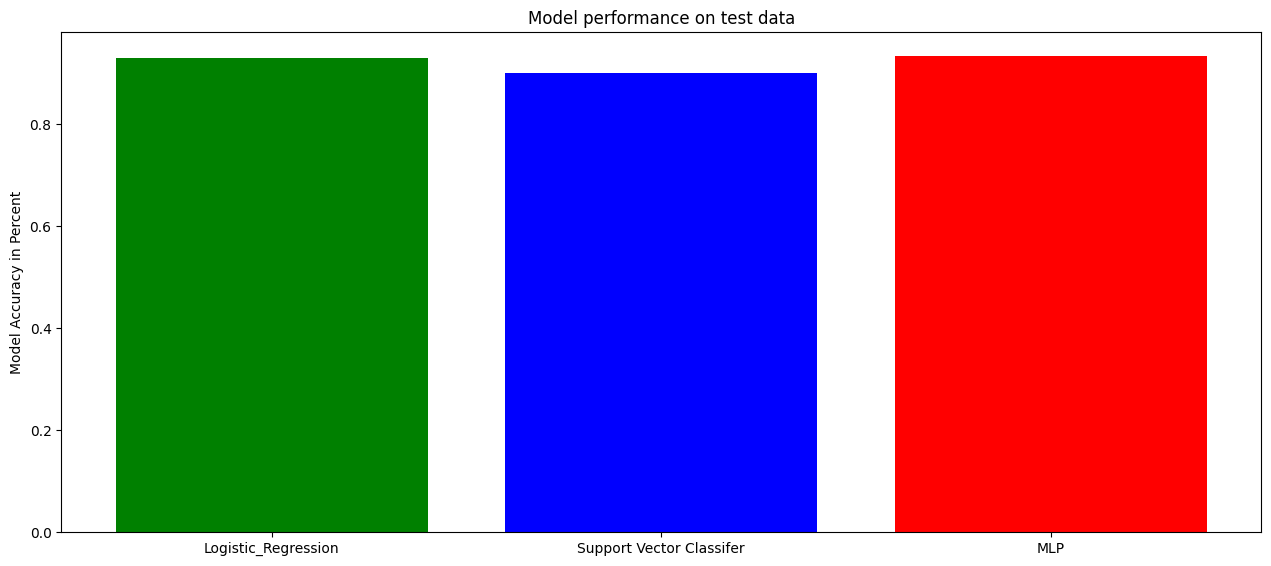

In [74]:
bar_dict = {'Logistic_Regression': 0.93, 
 'Support Vector Classifer': 0.901,
           "MLP": 0.934}
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Model Accuracy in Percent')
ax.set_title('Model performance on test data')

langs = list(bar_dict.keys())
students = list(bar_dict.values())
ax.bar(langs[0], students[0], color="g")
ax.bar(langs[1], students[1], color="b")
ax.bar(langs[2], students[2], color="r")
plt.show()